In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

lr = Ridge(alpha=0.1)
# model = GradientBoostingRegressor(n_estimators = 50, 
#                                 subsample=0.5,
#                                 random_state=0, 
#                                 loss='absolute_error', 
#                                 init=lr)
        
model = AdaBoostRegressor(estimator=lr, 
                        n_estimators = 60, 
                        random_state=0, 
                        learning_rate = 0.01)
# est = [('ridge', lr), ('gbr', grb), ('ada', ada)]
# model = VotingRegressor(estimators = est)

ohe = OneHotEncoder(handle_unknown = 'ignore')

In [3]:
df1 = pd.read_csv('DataSet/IPL_Ball_by_Ball_2008_2022.csv')
df2 = pd.read_csv('DataSet/IPL_Matches_Result_2008_2022.csv')

df1 = df1[df1.overs < 6]
df1 = df1[df1.innings < 3]
df2['year'] = pd.to_datetime(df2['Date'], format = "%Y/%m/%d").dt.year
df2 = df2[df2.year > 2015]
df = pd.merge(left=df1, right=df2, how='left', left_on='ID', right_on='ID')

df['BowlingTeam'] = np.where((df['BattingTeam'] == df['Team2']), df['Team1'], df['Team2'])

df.drop(['SuperOver', 'WinningTeam', 'WonBy', 'Margin',  'Season', 'player_out', 'kind','non_boundary','extra_type'
         ,'MatchNumber','fielders_involved','ballnumber', 'batsman_run','extras_run', 'non-striker', 'Team1','Team2', 
         'Umpire1', 'Umpire2', 'Team1Players', 'Team2Players', 'method', 'Player_of_Match', 'TossWinner', 'TossDecision',
         'City', 'Date'], axis=1, inplace=True)
df.head(2)

,ID,innings,overs,batter,bowler,total_run,isWicketDelivery,BattingTeam,Venue,year,BowlingTeam
0,1312200,1,0,YBK Jaiswal,Mohammed Shami,0,0,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",2022.0,Gujarat Titans
1,1312200,1,0,YBK Jaiswal,Mohammed Shami,1,0,Rajasthan Royals,"Narendra Modi Stadium, Ahmedabad",2022.0,Gujarat Titans


In [4]:
batter = df[['ID', 'batter','total_run']]

bat1 = batter.groupby(['ID', 'batter']).mean()
bat2 = batter.groupby(['ID', 'batter']).sum()
bat = pd.merge(left=bat1, right=bat2, how='left', left_on=['ID', 'batter'], right_on=['ID', 'batter'])
bat = bat.groupby('batter').mean()
bat.rename(columns = {'total_run_x':'strike_rate', 'total_run_y': 'total_run'}, inplace=True)
bat.replace(np.nan, 0, inplace=True)

batKmean = KMeans(n_clusters = 20, random_state=0, n_init="auto").fit(bat)
bat_cluster = {}
for i, index in enumerate(bat.index.values):
    bat_cluster[index] = batKmean.labels_[i]

bat

,strike_rate,total_run
batter,,
A Ashish Reddy,0.857143,6.00000
A Badoni,0.166667,1.00000
A Chopra,0.641111,5.80000
A Flintoff,1.400000,21.00000
A Manohar,1.000000,12.00000
...,...,...
YV Takawale,0.763359,16.00000
Yashpal Singh,0.527941,9.50000
Younis Khan,0.428571,3.00000


In [5]:
bowler = df[['ID', 'bowler', 'total_run', 'isWicketDelivery']]

ball = bowler.groupby(['ID','bowler']).sum()
ball = ball.groupby('bowler').mean()
ball['bowling_avg'] = ball['total_run'] / ball['isWicketDelivery']
ball.drop('total_run', axis=1, inplace=True)
ball.replace(np.nan, 0, inplace=True)
ball.replace(float('inf'), 175, inplace=True)

ballKmean = KMeans(n_clusters = 20, random_state=0, n_init="auto").fit(ball)

ball_cluster = {}
for i, index in enumerate(ball.index.values):
    ball_cluster[index] = ballKmean.labels_[i]

ball

,isWicketDelivery,bowling_avg
bowler,,
A Ashish Reddy,0.000000,175.000000
A Chandila,0.833333,13.900000
A Choudhary,0.750000,15.333333
A Dananjaya,0.000000,175.000000
A Flintoff,0.000000,175.000000
...,...,...
YA Abdulla,0.700000,14.714286
YK Pathan,0.416667,26.800000
YS Chahal,0.361702,30.705882


In [6]:
df.drop(['overs', 'isWicketDelivery'], axis=1, inplace = True)

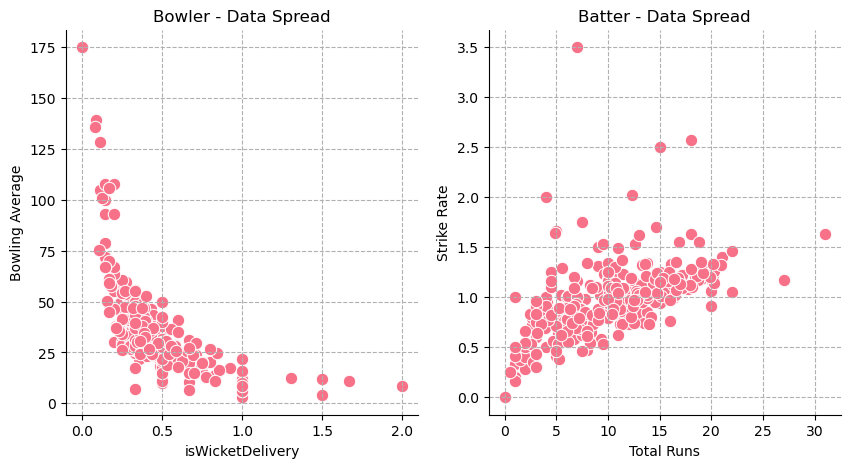

In [7]:
sns.set_palette('husl')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(data=ball, x='isWicketDelivery', y='bowling_avg', s=80, ax=axes[0])
axes[0].set_title('Bowler - Data Spread')
axes[0].set_xlabel('isWicketDelivery')
axes[0].set_ylabel('Bowling Average')
axes[0].tick_params(axis='both')
axes[0].grid(True, linestyle='--')
sns.despine(ax=axes[0])

sns.scatterplot(data=bat, x='total_run', y='strike_rate', s=80, ax=axes[1])
axes[1].set_title('Batter - Data Spread', )
axes[1].set_xlabel('Total Runs', )
axes[1].set_ylabel('Strike Rate')
axes[1].tick_params(axis='both')
axes[1].grid(True, linestyle='--')
sns.despine(ax=axes[1])

plt.show()

In [8]:
venue = {'Punjab Cricket Association Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
        'Rajiv Gandhi International Stadium, Uppal': 'Rajiv Gandhi International Stadium',
        'MA Chidambaram Stadium, Chepauk':'MA Chidambaram Stadium',
        'Sardar Patel Stadium, Motera': 'Sardar Patel Stadium', 
        'Brabourne Stadium, Mumbai': 'Brabourne Stadium',
        'Vidarbha Cricket Association Stadium, Jamtha': 'Vidarbha Cricket Association Stadium',
        'Punjab Cricket Association IS Bindra Stadium, Mohali': 'Punjab Cricket Association IS Bindra Stadium',
        'M Chinnaswamy Stadium': 'M.Chinnaswamy Stadium',
        'MA Chidambaram Stadium, Chepauk, Chennai': 'MA Chidambaram Stadium',
        'Wankhede Stadium, Mumbai': 'Wankhede Stadium', 
        'Narendra Modi Stadium, Ahmedabad': 'Narendra Modi Stadium',
        'Arun Jaitley Stadium, Delhi': 'Arun Jaitley Stadium', 
        'Zayed Cricket Stadium, Abu Dhabi': 'Zayed Cricket Stadium',
        'Dr DY Patil Sports Academy, Mumbai': 'Dr DY Patil Sports Academy',
        'Maharashtra Cricket Association Stadium, Pune': 'Maharashtra Cricket Association Stadium',
        'Eden Gardens, Kolkata': 'Eden Gardens'}

df.rename(columns={'batter':'batsmen', 'bowler':'bowlers', 'BattingTeam': 'batting_team', 
                   'Venue':'venue', 'BowlingTeam':'bowling_team'}, inplace=True)
df.replace({'venue': venue}, inplace = True)      

x1 =  pd.DataFrame(df.groupby(['ID', 'innings'])['batsmen'].unique().apply(list).reset_index(name="batsmen"))
x2 =  pd.DataFrame(df.groupby(['ID', 'innings'])['bowlers'].unique().apply(list).reset_index(name="bowlers"))

x3 = df.groupby(['ID', 'venue', 'innings', 'batting_team', 'bowling_team'], as_index=False).sum()
x4 = pd.merge(left=x1, right=x2, how='left', left_on=['ID', 'innings'], right_on=['ID', 'innings'])
df = pd.merge(left=x4, right=x3, how='right', left_on=['ID', 'innings'], right_on=['ID', 'innings']).drop(['ID'], axis=1)
df.head(5)

,innings,batsmen,bowlers,venue,batting_team,bowling_team,total_run,year
0,1,"[LMP Simmons, RG Sharma, HH Pandya, JC Buttler...","[RP Singh, I Sharma, MR Marsh]",Wankhede Stadium,Mumbai Indians,Rising Pune Supergiants,37,80640.0
1,2,"[AM Rahane, F du Plessis]","[MJ McClenaghan, JJ Bumrah]",Wankhede Stadium,Rising Pune Supergiants,Mumbai Indians,57,74592.0
2,1,"[MA Agarwal, Q de Kock, SS Iyer, KK Nair, SV S...","[AD Russell, UT Yadav, JW Hastings]",Eden Gardens,Delhi Daredevils,Kolkata Knight Riders,35,76608.0
3,2,"[RV Uthappa, G Gambhir]","[NM Coulter-Nile, Z Khan, CH Morris]",Eden Gardens,Kolkata Knight Riders,Delhi Daredevils,47,76608.0
4,1,"[M Vijay, M Vohra]","[P Kumar, PJ Sangwan, JP Faulkner, S Ladda]",Punjab Cricket Association IS Bindra Stadium,Kings XI Punjab,Gujarat Lions,52,72576.0


In [9]:
df_t = pd.read_csv('Input/test_file_matchid_12.csv').drop(['Unnamed: 0'], axis=1)
df_t

,venue,innings,batting_team,bowling_team,batsmen,bowlers
0,"Wankhede Stadium , Mumbai",1,Mumbai Indians,Chennai Super Kings,"RG Sharma, Ishan Kishan, Cameron Green","DL Chahar, TU Deshpande, Sisanda Magala, MJ Sa..."
1,"Wankhede Stadium , Mumbai",2,Chennai Super Kings,Mumbai Indians,"DP Conway, AM Rahane, RD Gaikwad","JP Behrendorff, Mohd Arsad Khan, Cameron Green..."


In [10]:
def encode_batter(row):
    zero=np.zeros(len(batKmean.cluster_centers_))
    for player in row['batsmen']:
        try:
            i = bat_cluster[player]
            zero[i] = 1
        except:
            pass
    return zero

def encode_bowler(row):
    zero=np.zeros(len(ballKmean.cluster_centers_))
    for player in row['bowlers']:
        try:
            i = ball_cluster[player]
            zero[i] = 1
        except:
            pass
    return zero

In [11]:
def preprocessing(df, test = 0, encode_features = ['venue','batting_team','bowling_team', 'innings']):
    if test:
        def spl(df, play):
            return df[play].split(', ')

        df['batsmen'] = df.apply(spl, axis = 1, args = ('batsmen', ))
        df['bowlers'] = df.apply(spl, axis = 1, args = ('bowlers', ))

        df['batsmen'] = df.apply(encode_batter, axis=1)
        df['bowlers'] = df.apply(encode_bowler, axis=1)
        
        one_hot = ohe.transform(df[encode_features]).toarray()
        hotencoded= pd.DataFrame(one_hot, index=df.index, columns = ohe.get_feature_names_out())
        k = len(ballKmean.cluster_centers_)
        vect_bat = pd.DataFrame(df['batsmen'].to_list(), columns=range(0, k))
        vect_ball = pd.DataFrame(df['bowlers'].to_list(), columns=range(k, k*2))

        df = pd.concat([vect_bat, vect_ball, hotencoded], axis=1)
        df.columns = df.columns.astype(str) 
        return df
    
    df['batsmen'] = df.apply(encode_batter, axis=1)
    df['bowlers'] = df.apply(encode_bowler, axis=1)
    
    one_hot = ohe.fit_transform(df[encode_features]).toarray()
    hotencoded= pd.DataFrame(one_hot, index=df.index, columns = ohe.get_feature_names_out())
    k = len(ballKmean.cluster_centers_)
    vect_bat = pd.DataFrame(df['batsmen'].to_list(), columns=range(0, k))
    vect_ball = pd.DataFrame(df['bowlers'].to_list(), columns=range(k, k*2))

    df = pd.concat([vect_bat, vect_ball, hotencoded, df[['total_run']]], axis=1)
    df.columns = df.columns.astype(str) 
    return df

In [12]:
def fit(df, test = 0):
    if test:
        pred = model.predict(df)
        return pred
    
    X_train = df.drop('total_run', axis=1)
    y_train = df['total_run']
    model.fit(X_train,y_train)
    return

In [13]:
df = preprocessing(df)
df_t = preprocessing(df_t, 1)
fit(df)

In [14]:
from sklearn.metrics import mean_absolute_error
mae = 0
for i in range(12, 46):
    test = pd.read_csv(f'Input/test_file_matchid_{i}.csv').drop(['Unnamed: 0'], axis=1)
    y = list(pd.read_csv(f'Input/test_file_labels_matchid_{i}.csv').actual_runs)
    test = preprocessing(test, 1)
    mae += mean_absolute_error(y, fit(test, 1))*2
    
print(mae)

675.4064685991841
